
# Проект «Статистический анализ данных»

## Задача
Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках.

Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

In [1]:
import pandas as pd
import numpy as np

from math import factorial
from math import sqrt

from scipy import stats as st
from scipy.stats import binom

import seaborn as sns
import matplotlib.pyplot as plt

## Загрузка данных

In [2]:
users = pd.read_csv('datasets/users_go.csv')
rides = pd.read_csv('datasets/rides_go.csv')
subs = pd.read_csv('datasets/subscriptions_go.csv')

Изучим каждый датафрейм в отдельности, чтобы понять, как в них размещены данные.  
### Пользователи

In [3]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


В таблице пользователей 1565 наблюдений, 5 столбцов:
1. `user_id`— id пользователя (целое число, отличающееся от индекса в таблице на +1)
2. `name` — имя пользователя (кириллицей с заглавной буквы)
3. `age` — возраст (целое число)
4. `city` — город (кириллицей с заглавной буквы)
5. `subscription_type` – тип подписки **ultra** или **free**

### Поездки

In [4]:
rides.info()
rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


В таблице поездок 18068 наблюдений, 4 столбца:
1. `user_id` — id пользователя (соответствует id из таблицы users)
2. `distance`— расстояние, которое пользователь проехал в наблюдаемой сессии (в метрах)
3. `duration` — продолжительность сессии (в минутах)
4. `date` — дата совершения поездки

### Подписки

In [5]:
subs.info()
subs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


В таблице две строки, описывающие типы подписки, и 4 столбца:
1. `subscription_type` — тип подписки **free** или **ultra**
2. `minute_price` —	стоимость одной минуты поездки по данной подписке
3. `start_ride_price` —	стоимость начала поездки
4. `subscription_fee` —	стоимость ежемесячного платежа

### Первые наблюдения
* В датасетах отстутствуют пропуски, что сократит время на предобработку
* Тип данных не приведён в соответствие только в одном столбце `date`

## Предобработка данных

### Приведение типов
Столбец `date` таблицы `rides` необходимо привести к типу `datetime64`:

In [6]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

rides.info()
rides.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


,user_id,distance,duration,date
0,1,4409.91914,25.599769,2021-01-01


Зачения в столбце `date` внешне не изменились, но тип данных стал `datetime64`, значит преобразование проведено верно.

### Добавление дополнительных столбцов
Создадим новый столбец с номером месяца на основе столбца `date`:

In [7]:
rides['month'] = rides['date'].dt.month
rides.tail(2)

,user_id,distance,duration,date,month
18066,1534,2902.308661,16.674362,2021-11-27,11
18067,1534,2371.711192,15.893917,2021-12-29,12


Столбец в таблице появлися, номер месяца выбирается верно.

Создадим столбец `year`на основе столбца `date`

In [8]:
rides['year'] = rides['date'].dt.year
rides.tail(2)

,user_id,distance,duration,date,month,year
18066,1534,2902.308661,16.674362,2021-11-27,11,2021
18067,1534,2371.711192,15.893917,2021-12-29,12,2021


Проверим данные за какие годы есть в датасете:

In [9]:
rides['year'].unique()

array([2021], dtype=int32)

### Обработка пропусков
Ещё раз провеврим таблицы `users` и `rides` на наличие пропусков:

In [10]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [11]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
year        0
dtype: int64

Пропуски в данных отсутствуют.

### Обработка дубликатов
Проверим, есть ли в таблицах `users` и `rides` дубликаты: 

In [12]:
users.duplicated().sum()

31

In [13]:
rides.duplicated().sum()

0


Дубликаты нашлись только в таблице `users`, посмотрим на них повнимательнее:

In [14]:
users[users.duplicated()].tail()

,user_id,name,age,city,subscription_type
1560,829,Федор,29,Пятигорск,free
1561,809,Юрий,26,Сочи,free
1562,307,Ясмина,19,Краснодар,ultra
1563,47,Юрий,28,Тюмень,ultra
1564,1045,Артемий,28,Ростов-на-Дону,free


`user_id` и индексы значительно отличаются, следовательно, это точно дубликаты и мы можем смело с ними попрощаться:

In [15]:
users.drop_duplicates(inplace=True)
users.duplicated().sum()

0

### Результаты предобработки
Пропуско в данных не обнаружено, дубликаты отброшены.

## Шаг 3. Исследовательский анализ данных

### Частота встречаемости городов

Сгруппируем города с помощью сводной таблицы и посчитаем количество пользователей в каждом городе:

In [16]:
cities_count = users.pivot_table(index='city',
                                 values='user_id',
                                 aggfunc='count')

cities_count = cities_count.sort_values('user_id', ascending=False)

Визуализируем полученные данные:

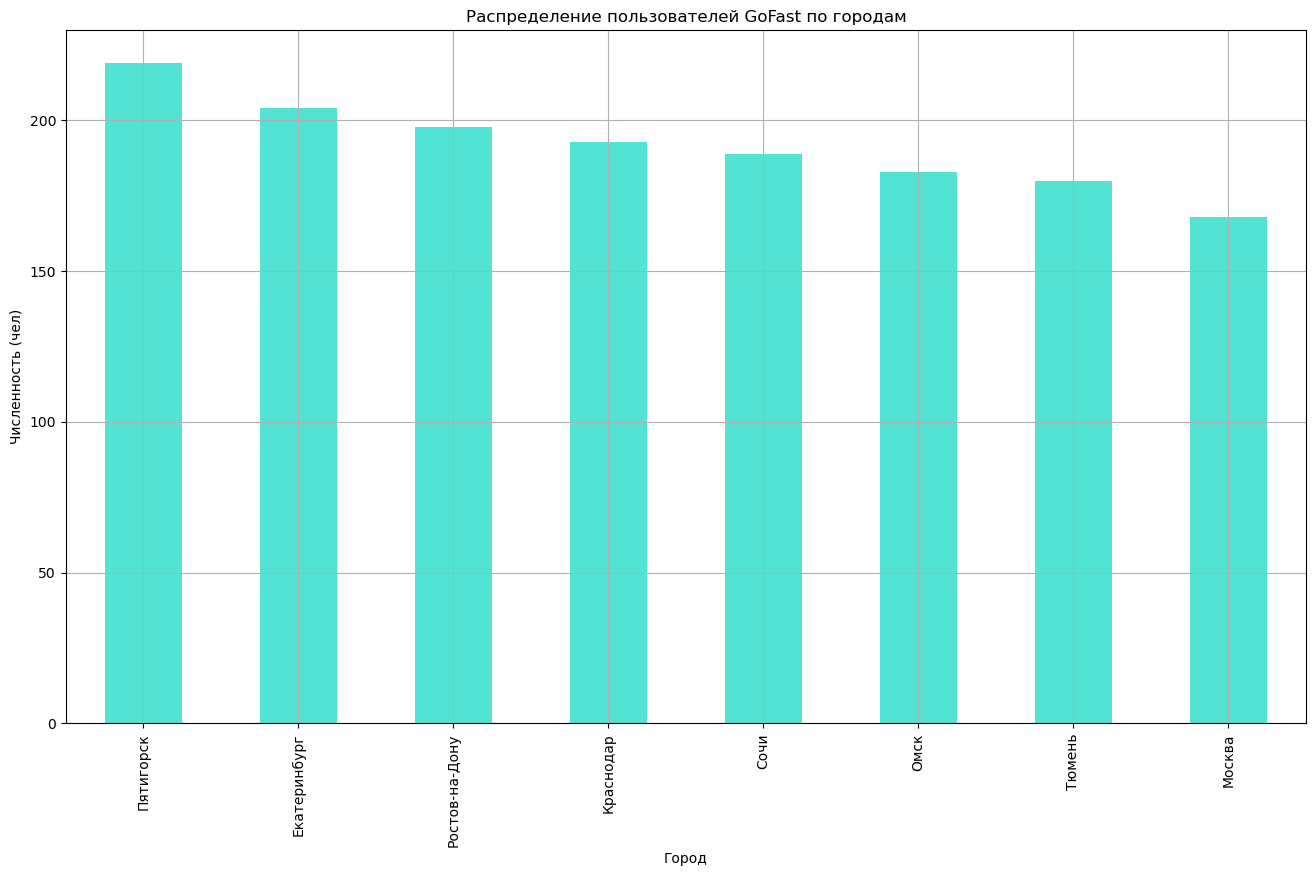

In [17]:
chart = cities_count.plot(kind='bar',

                          title='Распределение пользователей GoFast по городам',
                          xlabel='Город',
                          ylabel='Численность (чел)',
                          legend='',
                          
                          color='turquoise',
                          figsize=(16, 9), 
                          grid = True,
                          alpha = 0.9
                         )

plt.show()

**Наблюдения**
* Сервис  GoFast представлен в 8-ми городах
* Больше всего пользователей в Пятигорске
* Меньше всего — в Москве

### Соотношение пользователей с подпиской и без подписки

Сгруппируем пользователей по типу подписки:

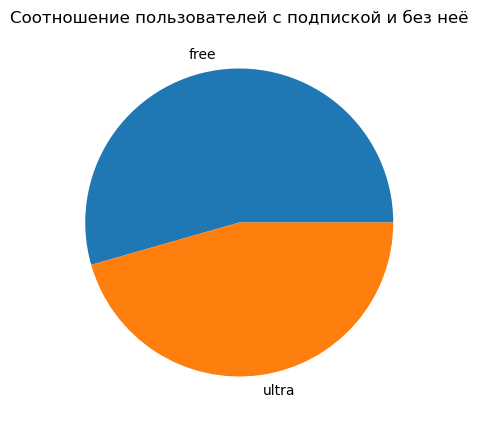

In [18]:
users_by_sub = users.groupby('subscription_type')['user_id'].count()
users_by_sub.plot(kind='pie',
                  title='Соотношение пользователей с подпиской и без неё',
                  ylabel='',
                  figsize=(5, 5))
plt.show()

Подсчитаем соотношение и округлим его до 2-х знаков после запятой:

In [19]:
subscription_ratio = users_by_sub.loc['free'] / users_by_sub.loc['ultra']
round(subscription_ratio, 2)

1.19

**Наблюдения**
* Количество пользователей с подпиской free на 19% выше, чем количество пользователей ultra

### Возраст пользователей
Посмотрим на распределение и гистограмму:

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

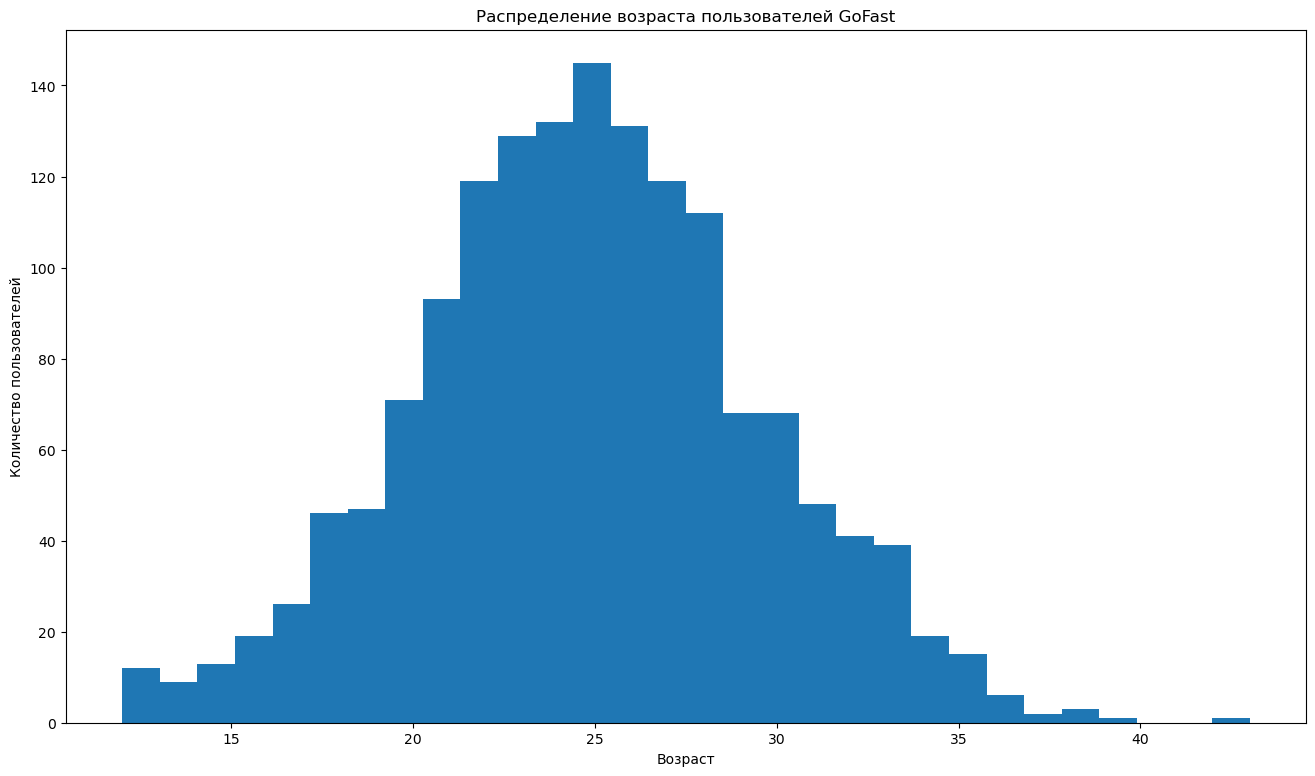

In [20]:
users.plot(kind='hist',
           title = 'Распределение возраста пользователей GoFast',
           
           y='age',
           bins=30,
           
           figsize=(16, 9),
           legend=False)

plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')

users['age'].describe()

**Наблюдения**
* График максимально похож на нормальное распределение
* Самым молодым пользователям 12 лет
* Самым взрослым — 43 года
* Больше всего пользователей в возрасте 25 лет

### Расстояние, которое пользователь преодолел за одну поездку
Проверим, нет ли выбросов и нулевых значений в данных:

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

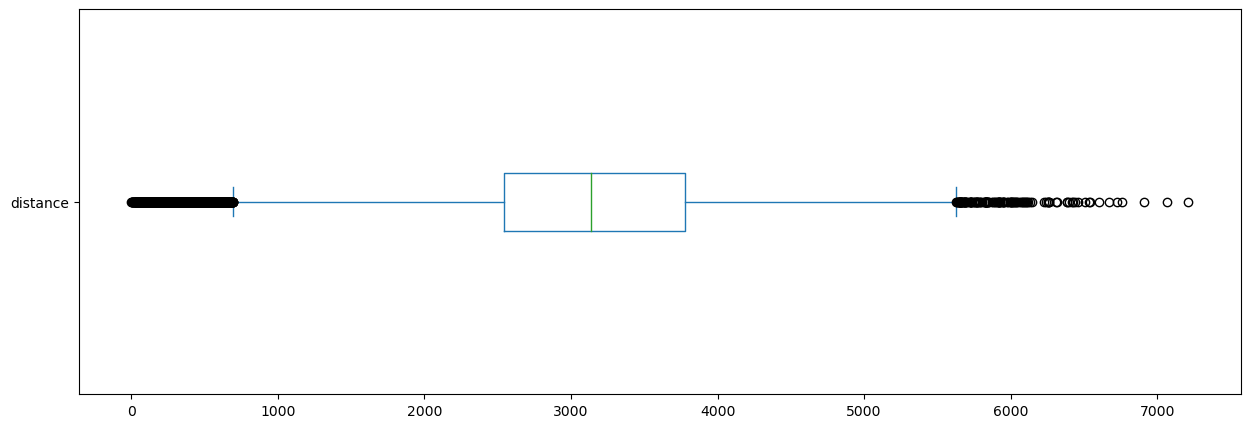

In [21]:
rides['distance'].plot.box(vert=False, figsize =(15,5))
rides['distance'].describe()

Нулевые значения отсутствуют. 
Чтобы понять, что делать с выбросами, для начала вычислим значения верхнего и нижнего «усов» диаграммы размаха:

In [22]:
lower_whisker = rides['distance'].quantile(0.25) - 1.5 * st.iqr(rides['distance'])
upper_whisker = rides['distance'].quantile(0.75) + 1.5 * st.iqr(rides['distance'])

print('Нижний:', int(lower_whisker), '\nВерхний:', int(upper_whisker))

Нижний: 693 
Верхний: 5625


Теперь проверим, насколько реальны поездки, кототрые на диаграмме отображаются как выбросы. 
* **Короткие поездки**  

Построим диаграмму рассеивания:

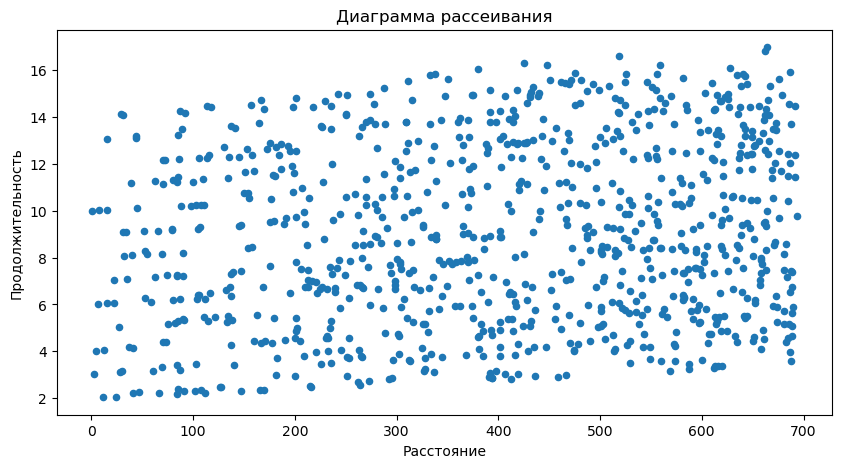

In [23]:
rides.loc[rides['distance'] < lower_whisker].plot(kind='scatter',
                                                  x='distance',
                                                  y='duration',
                                                  
                                                  title='Диаграмма рассеивания',
                                                  xlabel='Расстояние',
                                                  ylabel='Продолжительность',
                                                  figsize=(10, 5))
plt.show()

Несмотря на то, что диаграмма получилась хаотичной, все поездки в ней реальные и тоже являются частью статистики.
* Продолжительные поездки с близким к нулю перемещением могут быть объяснены, например, неисправностью GPS на самокате или какими-то другими факторами. Но в любом случае, они учтены и принесли выручку, следовательно, выбросами не являются.

---

* **Длинные поездки**

<Axes: title={'center': 'Диаграмма рассеивания'}, xlabel='Расстояние', ylabel='Продолжительность'>

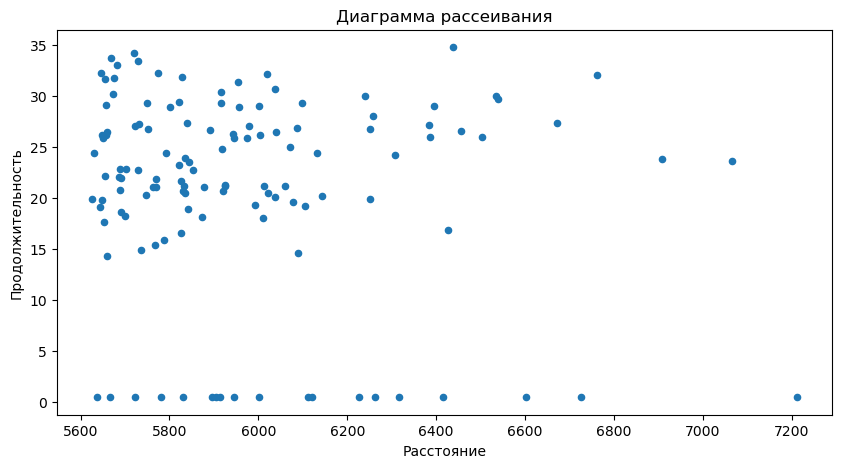

In [24]:
rides.loc[rides['distance'] > upper_whisker].plot(kind='scatter',
                                                  x='distance',
                                                  y='duration',
                                                  
                                                  title='Диаграмма рассеивания',
                                                  xlabel='Расстояние',
                                                  ylabel='Продолжительность',
                                                  figsize=(10, 5))

На диаграмме видны очень непродолжительные поездки менее минуты. С ними мы будем разбираться на следующем шаге. Все остальные поездки не являются выбросами, так как имеют адекатную среднюю скорость. Поэтому оставим их в датасете.  

Ещё раз вглянем на столбец `distance`, чтобы лучше описать наблюдения:

In [25]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

**Наблюдения**
* В данных по поездкам остутствуют нулевые значения
* Самая короткая поездка составляет 694 м
* Самая длинная — 7211 м
* Чаще всего пользователи выбирают самокат, чтобы проехать на нём около 3,2 км.

### Продолжительность поездок

Проверим, нет ли выбросов и нулевых значений в данных:

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

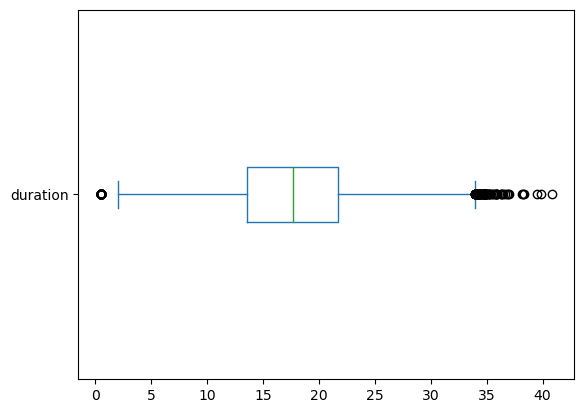

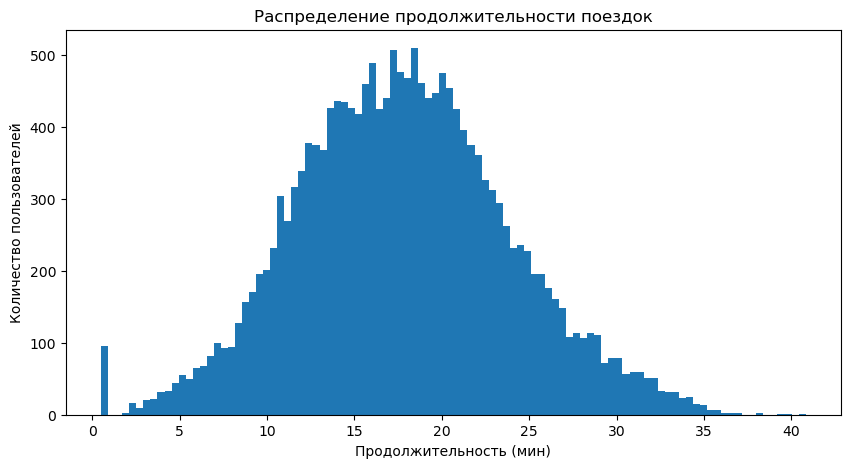

In [26]:
rides['duration'].plot.box(vert=False)
rides.plot(kind='hist',
           title = 'Распределение продолжительности поездок',
           y='duration',
           bins=100,
           figsize=(10, 5),
           legend=False)
plt.xlabel('Продолжительность (мин)')
plt.ylabel('Количество пользователей')

rides['duration'].describe()

Наблюдается значительный выброс в данных для очень коротких поездок (менее 2 минут). Увеличим масштаб и присмотримся повнимательнее:

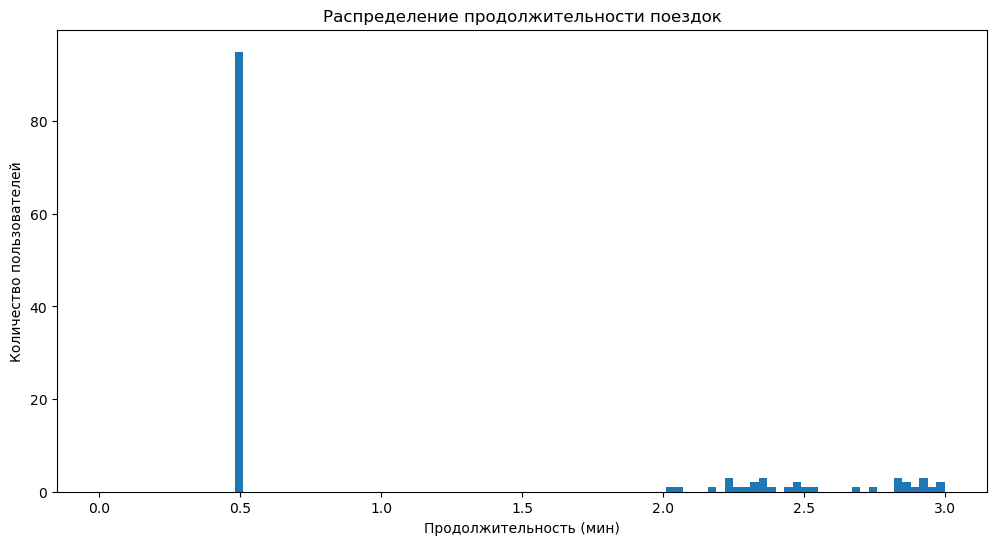

In [27]:
rides.plot(kind='hist',
           title = 'Распределение продолжительности поездок',           
           y='duration',
           bins=100,
           range=(0, 3),
           figsize=(12, 6),
           legend=False)

plt.xlabel('Продолжительность (мин)')
plt.ylabel('Количество пользователей')
plt.show()

Если верить значениям, то большое число поездок закончилось через 30 секунд. Так как за это время нельзя проехать по городу 600+ метров, речь может идти либо об ошибке в данных, либо о несостоявщихся поездках.  
Посмотрим на то, какой длины были поездки продолжительностью менее минуты:

In [28]:
rides[rides['duration'] < 1.0].head(10)

,user_id,distance,duration,date,month,year
6531,701,4196.445201,0.5,2021-08-31,8,2021
6570,704,4830.824371,0.5,2021-10-14,10,2021
6680,712,4684.004397,0.5,2021-03-04,3,2021
6695,713,5215.642710,0.5,2021-02-25,2,2021
6768,718,5197.436649,0.5,2021-02-11,2,2021
6860,724,6225.520342,0.5,2021-12-16,12,2021
6883,726,4452.491518,0.5,2021-03-01,3,2021
7018,735,4406.954812,0.5,2021-04-13,4,2021
7160,745,5286.167732,0.5,2021-08-17,8,2021
7364,760,4881.391865,0.5,2021-08-29,8,2021


Везде расстояния в 4-5 километров, которые на самокате можно преодолеть за полчаса, а не за полминуты. Поправим этот момет, домножив малые значения на 60:

In [29]:
rides.loc[rides['duration'] < 1.0, 'duration'] *= 60

Взглянем теперь на обновлённые данные:

count    18068.000000
mean        17.960120
std          6.023636
min          2.035632
25%         13.697117
50%         17.750643
75%         21.824361
max         40.823963
Name: duration, dtype: float64

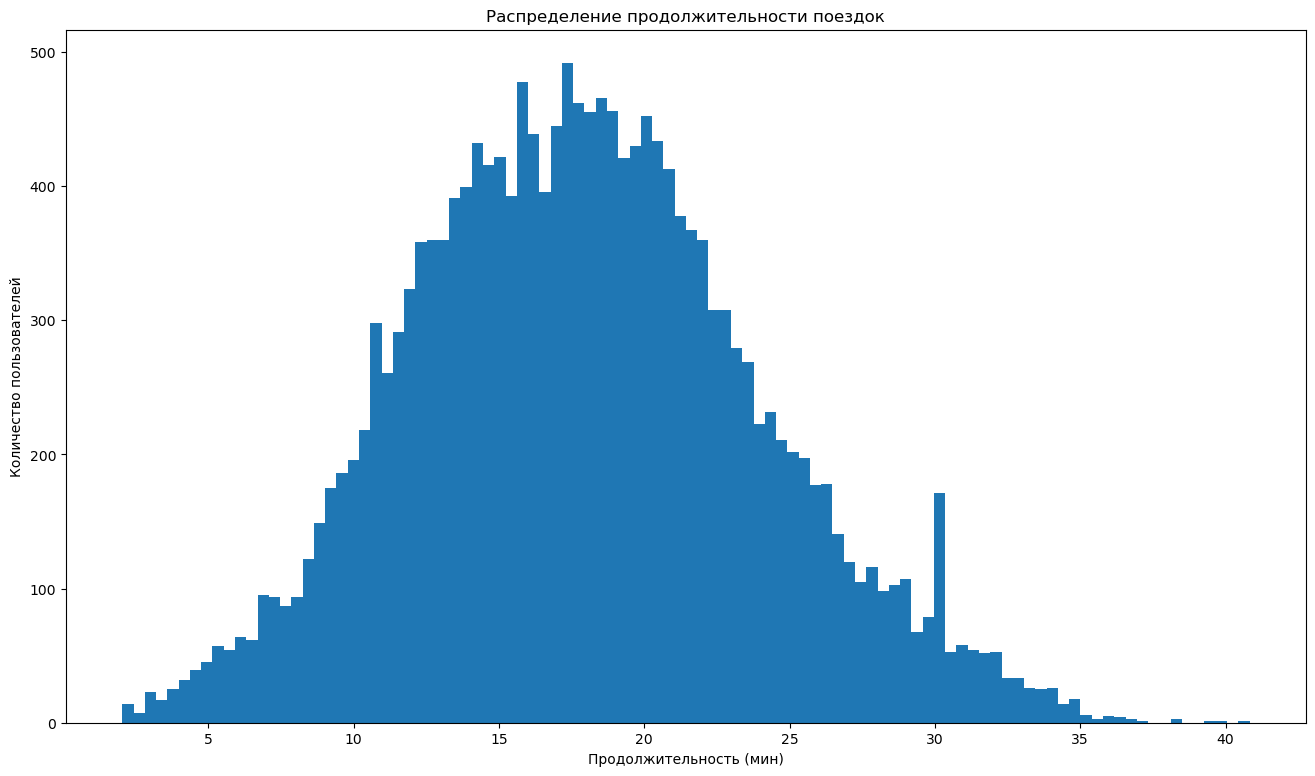

In [30]:
rides.plot(kind='hist',
           title = 'Распределение продолжительности поездок',           
           y='duration',
           bins=100,

           figsize=(16, 9),
           legend=False)

plt.xlabel('Продолжительность (мин)')
plt.ylabel('Количество пользователей')

rides['duration'].describe()

**Наблюдения**
* Самые короткие поездки имеют продолжительность в 2 минуты
* Самые долгие — около 40 минут
* Чаще всего пользователи проводят в поездке около 17 минут

## Шаг 4. Объединение данных

### Единый датафрейм
Округлим продолжительность поездок в исходном датафрейме `rides` в большую сторону:

In [31]:
rides['duration'] = np.ceil(rides['duration'])
rides.head()

,user_id,distance,duration,date,month,year
0,1,4409.919140,26.0,2021-01-01,1,2021
1,1,2617.592153,16.0,2021-01-18,1,2021
2,1,754.159807,7.0,2021-04-20,4,2021
3,1,2694.783254,19.0,2021-08-11,8,2021
4,1,4028.687306,27.0,2021-08-28,8,2021


Объединим данные о пользователях, поездках и подписках в один датафрейм. Воспользуемся методом `merge()`:

In [32]:
print(rides.shape, users.shape, subs.shape)

(18068, 6) (1534, 5) (2, 4)


Строк 18068, столбцов 6 + (5-1) + (4-1) = 13

In [33]:
data = users.merge(rides, on='user_id').merge(subs, on='subscription_type')
data.shape

(18068, 13)

### Дополнительные датафреймы

* **Пользователи без подписки** — датафрейм по параметру `free` в столбце `subscription_type`
* **Пользователи с подпиской** — датафрейм по параметру `ultra` в столбце `subscription_type`

In [34]:
data_free = data.loc[data['subscription_type'] == 'free']
data_ultra = data.loc[data['subscription_type'] == 'ultra']

### Визуализация
Наглядно представим информацию о расстоянии и времени поездок для пользователей обеих категорий.
* **Расстояния**

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

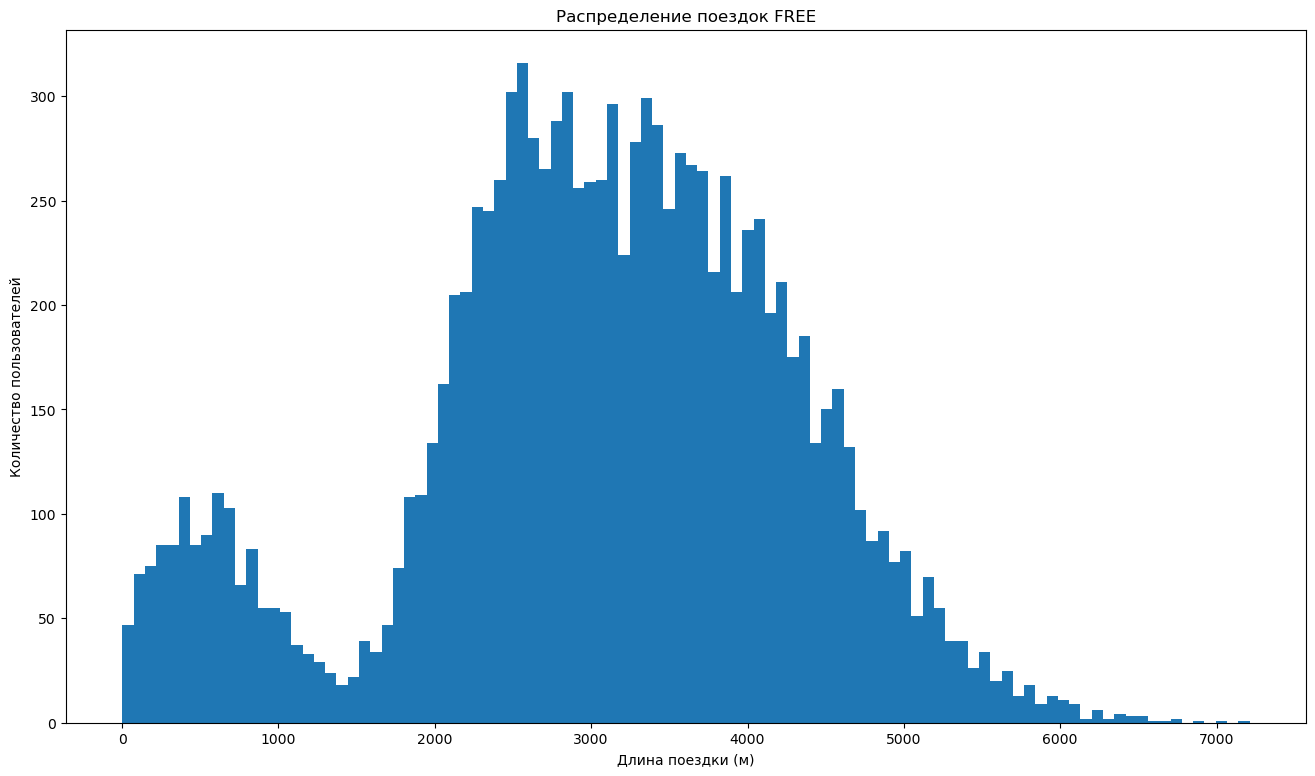

In [35]:
data_free.plot(kind='hist',
           title = 'Распределение поездок FREE',           
           y='distance',
           bins=100,
           figsize=(16, 9),
           legend=False)

plt.xlabel('Длина поездки (м)')
plt.ylabel('Количество пользователей')

data_free['distance'].describe()

---

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

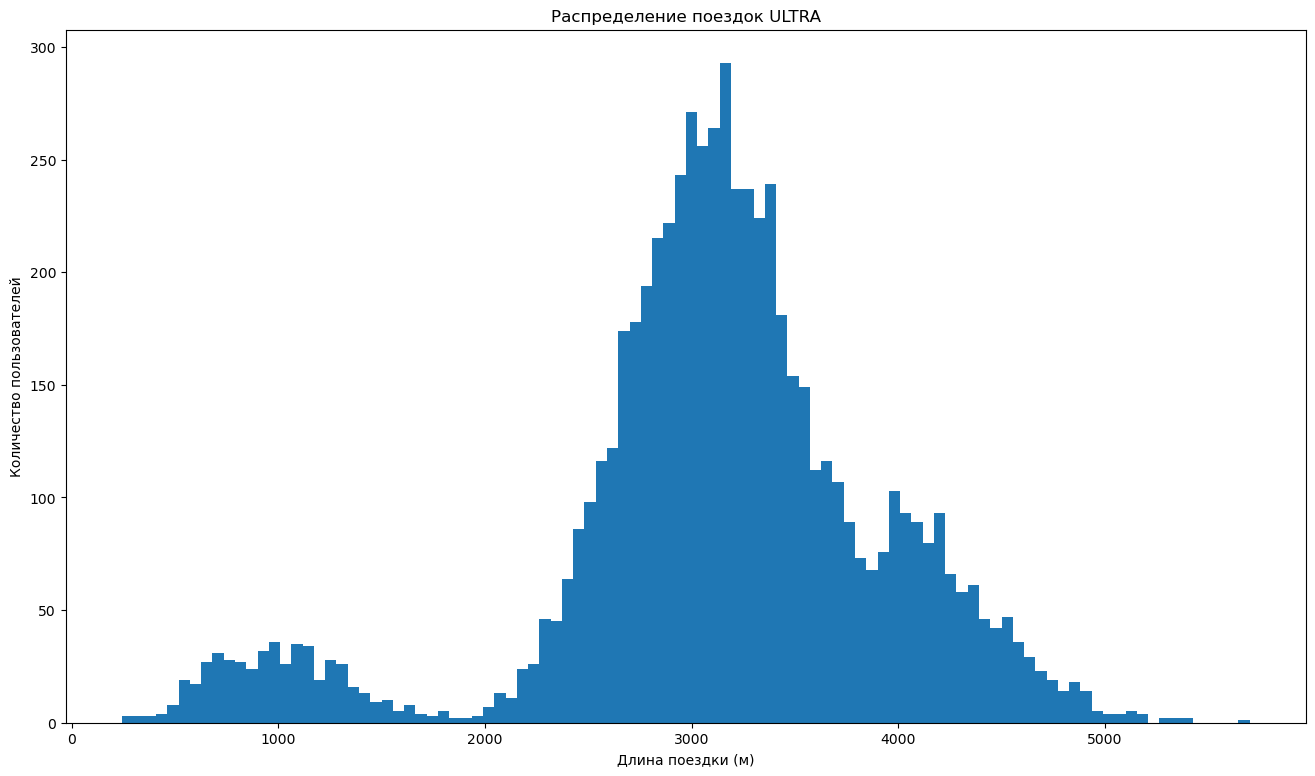

In [36]:
data_ultra.plot(kind='hist',
           title = 'Распределение поездок ULTRA',           
           y='distance',
           bins=100,
           figsize=(16, 9),
           legend=False)

plt.xlabel('Длина поездки (м)')
plt.ylabel('Количество пользователей')
data_ultra['distance'].describe()

**Наблюдения**
* Обе категории подписчиков чаще выбирают самокат, чтобы проехать расстояние около 3,2 км
* Пользователи с подпиской **free**, как правило ездят дальше, чем пользователи с подпиской **ultra**

* **Продолжительность поездок**

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

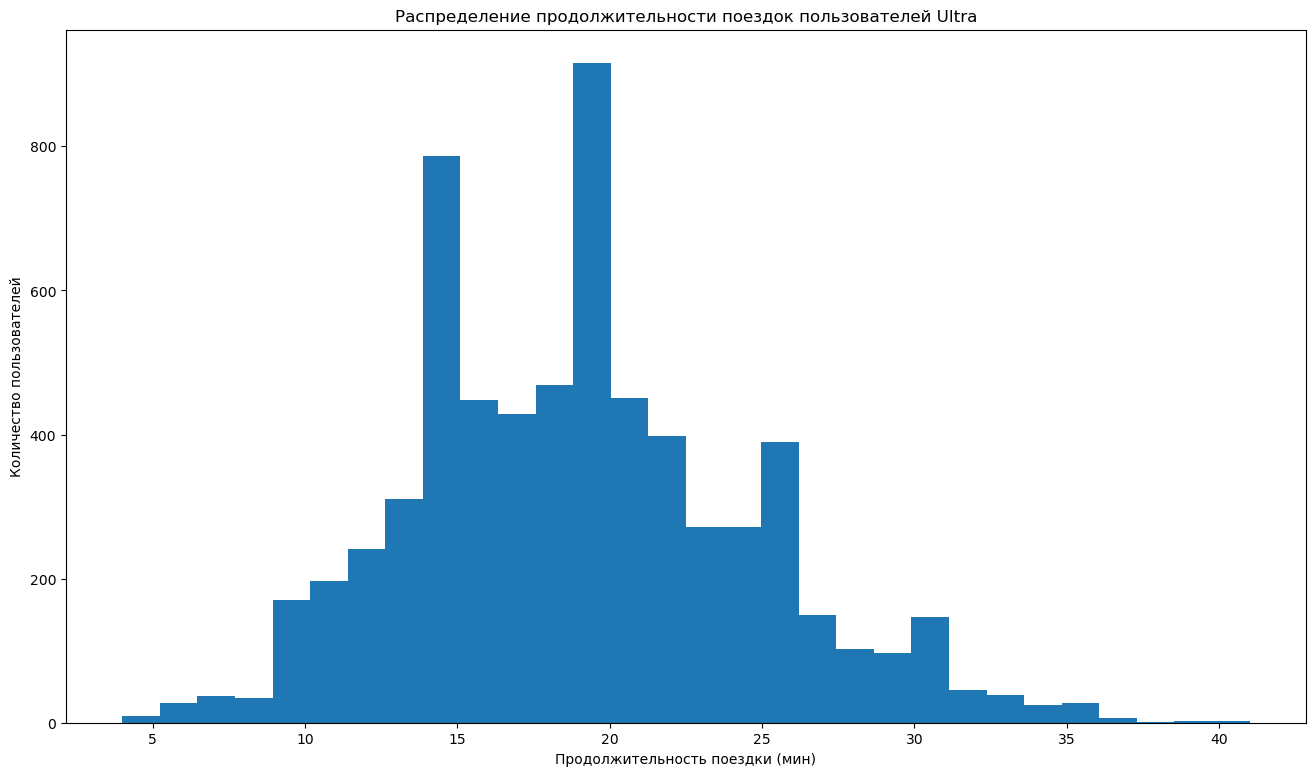

In [37]:
data_ultra.plot(kind='hist',
           title = 'Распределение продолжительности поездок пользователей Ultra',           
           y='duration',
           bins=30,
           figsize=(16, 9),
           legend=False)

plt.xlabel('Продолжительность поездки (мин)')
plt.ylabel('Количество пользователей')

data_ultra['duration'].describe()

count    11568.000000
mean        18.129149
std          6.235092
min          3.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

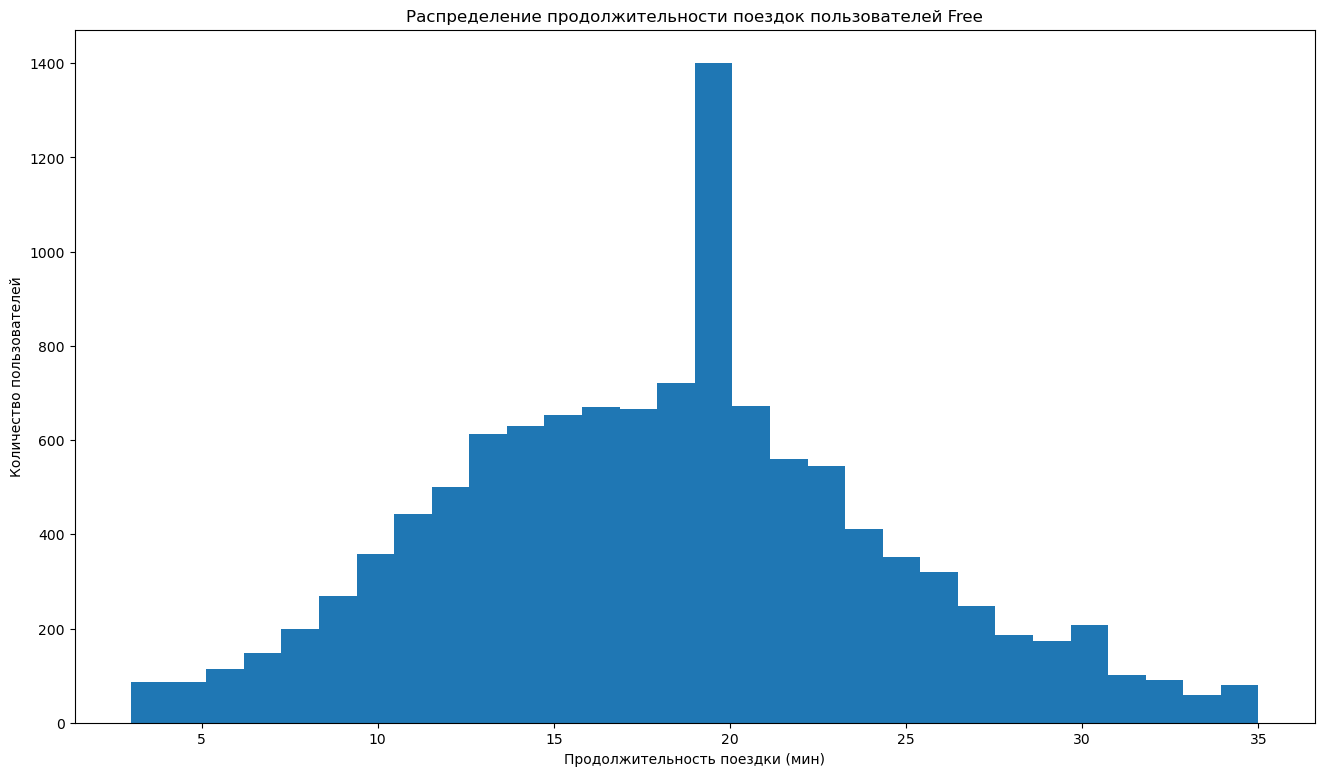

In [38]:
data_free.plot(kind='hist',
           title = 'Распределение продолжительности поездок пользователей Free',           
           y='duration',
           bins=30,
           figsize=(16, 9),
           legend=False)

plt.xlabel('Продолжительность поездки (мин)')
plt.ylabel('Количество пользователей')

data_free['duration'].describe()

**Наблюдения**
* В среднем, обе категории пользователей пользуются самокатом около 19-ти минут.
* Пользователи с подпиской **ultra**, как правило, проводят в поездках больше времени и ездят медленне, чем пользователи с подпиской **free**.

## Шаг 5. Подсчёт выручки

### Агрегация

Создадим датафрейм с агрегированными данными. Найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.  
Сразу добавим столбцы `subscription_fee`, `start_ride_price` и `minute_price`, чтобы упростить работу на следующем шаге:

In [39]:
revenue_data = pd.pivot_table(
    data,
    index=['user_id', 'month'],
    values=['distance', 'duration', 'date', 'subscription_fee', 'start_ride_price', 'minute_price' ],
    aggfunc={'distance': np.sum,
             'duration': np.sum,
             'date' : 'count',
             'subscription_fee': 'first',
             'start_ride_price':'first',
             'minute_price': 'first'
            }
)

# Коректировка индексов и названий столбцов
revenue_data = revenue_data.reset_index()
revenue_data = revenue_data.rename(columns =
                                   {'date': 'count',
                                    'distance': 'month_distance',
                                    'duration': 'month_duration'}
                                  )
revenue_data.head()

,user_id,month,count,month_distance,month_duration,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.511294,42.0,6,0,199
1,1,4,1,754.159807,7.0,6,0,199
2,1,8,2,6723.470560,46.0,6,0,199
3,1,10,2,5809.911100,32.0,6,0,199
4,1,11,3,7003.499363,56.0,6,0,199


### Подсчёт выручки

Добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Рассчитаем её по формуле:

*Выручка = стоимость подписки + (стоимость старта поездки ×  количество поездок) +  
\+ (стоимость одной минуты поездки × общая продолжительность всех поездок в минутах)*

In [40]:
revenue_data['month_revenue'] = revenue_data['subscription_fee'] +\
(revenue_data['start_ride_price'] * revenue_data['count'] + \
(revenue_data['minute_price'] * revenue_data['month_duration']))

revenue_data.head()

,user_id,month,count,month_distance,month_duration,minute_price,start_ride_price,subscription_fee,month_revenue
0,1,1,2,7027.511294,42.0,6,0,199,451.0
1,1,4,1,754.159807,7.0,6,0,199,241.0
2,1,8,2,6723.470560,46.0,6,0,199,475.0
3,1,10,2,5809.911100,32.0,6,0,199,391.0
4,1,11,3,7003.499363,56.0,6,0,199,535.0


## Шаг 6. Проверка гипотез

### Гипотеза №1
***Пользователи с подпиской тратят больше времени на поездки.***

Из-за формулировки `больше`, данная гипотеза встаёт на место H1:

* **H0** — среднее время поездки пользователей **ultra** меньше или равно среднему времени поездки пользователей **free**  
* **H1** — среднее время поездки пользователей **ultra** больше среднего времени поездки пользователей **free**

Подготовим данные для t-теста:

In [41]:
duration_ultra = data.loc[data['subscription_type'] == 'ultra']['duration'].values
duration_free = data.loc[data['subscription_type'] == 'free']['duration'].values

Проверим количество значений в каждом массиве:

In [42]:
print(f'Ultra: {len(duration_ultra)}, Free: {len(duration_free)}')

Ultra: 6500, Free: 11568


Количество значений различается, поэтому параметр `equal_var=False`. А так как в H1 гипотеза `больше`, параметер `alternative='greater'`

In [43]:
alpha = .05

results = st.ttest_ind(
    duration_ultra,
    duration_free,
    equal_var=False,
    alternative='greater')

print(f'p-value: {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 4.655799681180463e-24
Отвергаем нулевую гипотезу


**Вывод**  
* Так как нулевая гипотеза отвергнута и она была противоположной формулировке заказчика, нет основания отвергать гипотезу о том, что пользователи с подпиской тратят больше времени на поездки.

---

### Гипотеза №2
***Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.***

* **H0** — среднее расстояние поездки пользователей **ultra** меньше или равно 3130 м.
* **H1** — среднее расстояние поездки пользователей **ultra** больше 3130 м.

Подготовим данные для t-теста:

In [44]:
distance_ultra = data.loc[data['subscription_type'] == 'ultra']['distance'].values

Проверим гипотезу с помощью метода  `ttest_1samp()` c параметром `alternative='greater'` 

In [45]:
mu = 3130 # среднее
alpha = .05 # уровень статистической значимости

results = st.ttest_1samp(
    distance_ultra, 
    mu,
    alternative='greater')

print('p-value:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-value: 0.9195368847849785
Не отвергаем нулевую гипотезу


**Вывод**  
* Нет основания отвергать гипотезу о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

---

<div style="background-color:lavender; color:#black; text-align:center; padding:2%">
    
**Алексей:** ✋ Здесь буду рассуждать так же как в Гипотезе №1, оформлю в том же ключе. Исправленная версия гипотезы:

    

### Гипотеза №3
***Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.***

Из-за формулировки `выше`, то есть `больше`, данная гипотеза встаёт на место H1

* **H0** — средняя помесячная выручка от пользователей **ultra** меньше или равна выручке от пользователей **free**
* **H1** — средняя помесячная выручка от пользователей **ultra** больше чем выручка от пользователей **free**

Подготовим данные для t-теста:

In [46]:
month_revenue_ultra = revenue_data.loc[revenue_data['subscription_fee'] > 0]['month_revenue'].values
month_revenue_free = revenue_data.loc[revenue_data['subscription_fee'] == 0]['month_revenue'].values

<div style="background-color:lavender; color:#black; text-align:center; padding:2%">
    
**Алексей:** 👇 Внесу исправления в сушествующий код и вывод 👇
   

<div class="alert alert-success">

**Артём:** 👍 Хорошо.

</div>

Проверим гипотезу с помощью метода  `ttest_ind()` c параметром `alternative='greater'` 

In [47]:
alpha = .05 # уровень статистической значимости

results = st.ttest_ind(
    month_revenue_ultra,
    month_revenue_free,
    alternative='greater')

print(f'p-value: {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 7.430720991422216e-26
Отвергаем нулевую гипотезу


**Вывод**  
* Так как нулевая гипотеза отвергнута и она была противоположной формулировке заказчика, нет основания отвергать гипотезу о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

---

### Гипотеза №4
***Из-за обновления сервера количество обращинй в поддержку снизилось***  
Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест понадобился бы для проверки этой гипотезы?

Так как в формулировке `снизилось` = `меньше`, то данная гипотеза встанет на место H1:
* **H0** — среднее количество обращений после обновлений стало **больше** или **не изменилось**
* **H1** — среднее количество обращений после обновлений стало **меньше**

**Ответ**  
Гипотеза правосторонняя, следовательно, для её проверки понадобился бы **t-тест** `st.ttest_rel(time_before, time_after, alternative='less')` с параметрами: 

* `time_before`, `time_after` — массивы, которые содержат выборки до обновления сервера и после
* `alternative='less'` — альтернативная гипотеза о том, что истинное среднее до изменения меньше, чем истинное среднее после изменения

## Шаг 7. Распределения

### Промокоды
Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. По завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.
 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают  10 % пользователей. 

**Задача**
1. Выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.
2. Подобрать параметры распределения, описывающего эту ситуацию, построить график распределения и сформулировать ответ на вопрос о количестве промокодов.

**Анализ**  
Распределение биномиальное, так как попытки независимы между собой и имеют всего два исхода (продлил — не продлил).


* План — 100 клиентов должны продлить подписку (100 успехов)
* Вероятность продления — 10%
* Вероятность 5% не выполнить план равна вероятности 95% план выполнить (95%-я вероятность для 100 успехов)

Формула биномиального распределения имеет вид:
$$P(X=k) = C(N, k) * p^{k} * (1-p)^{(N-k)}$$

Где:
* $P(X=k)$ - вероятность того, что из N промокодов будет продлено ровно k подписок,
* $C(N, k)$ - число сочетаний из N по k,
* $p$ - вероятность продления подписки (0.1),
* $N$ - общее количество рассылаемых промокодов,
* $k$ - количество продлений подписки.

Необходимо найти $N$ такое, что $P(X>=100) >= 0.95$

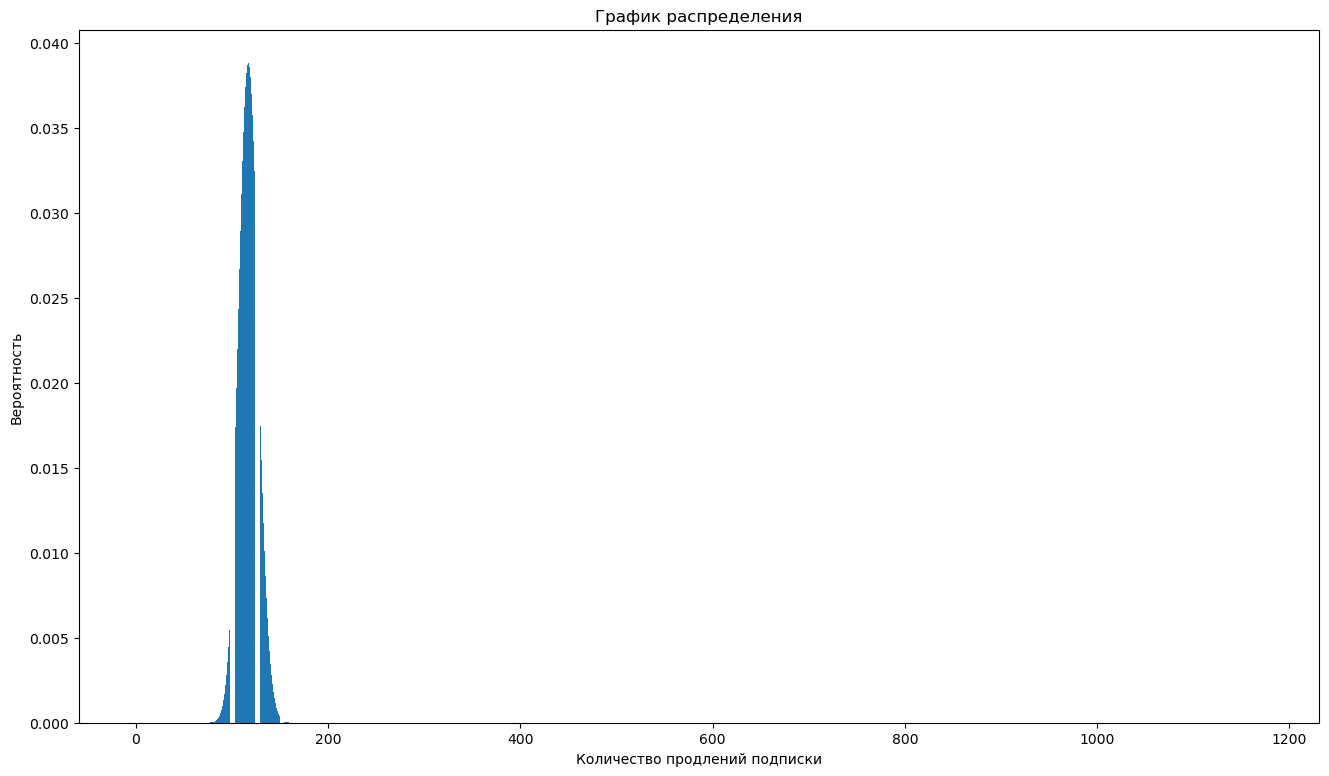

Минимальное количество промокодов: 1172


In [48]:
p = 0.1                   # Вероятность продления подписки
threshold = 100           # Порог в 100 продлений
target_probability = 0.95 # Целевая вероятность выполнения плана

N = 1
prob = 0

while prob < target_probability:
    distrib = st.binom(N, p)          # Биномиальное распределение для заданных N и p
    prob = 1 - distrib.cdf(threshold) # Вероятность не выполнить план
    N += 1

x = range(N)
y = [distrib.pmf(k) for k in x] # Вероятность, что количество продлений подписок будет равно k.

plt.figure(figsize=(16, 9))
plt.bar(x, y)
plt.xlabel('Количество продлений подписки')
plt.ylabel('Вероятность')
plt.title('График распределения')
plt.show()

print(f'Минимальное количество промокодов: {N-1}')

**Ответ:**  
Необходимо разослать минимум 1172 промокода, чтобы вероятность не выполнить план по продлённым подпискам была примерно 5%.

---

### Push-уведомления
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать
1 млн уведомлений.

**Задача**
* С помощью аппроксимации необходимо построить примерный график распределения и оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

**Анализ**  
Распределение биномиальное, так как попытки независимы между собой и имеют всего два исхода (открыл — не открыл).


* Попытки — 1 млн уведомлений
* План — не более 399,5 тыс пользователей откроют уведомление
* Вероятность открытия — 40%

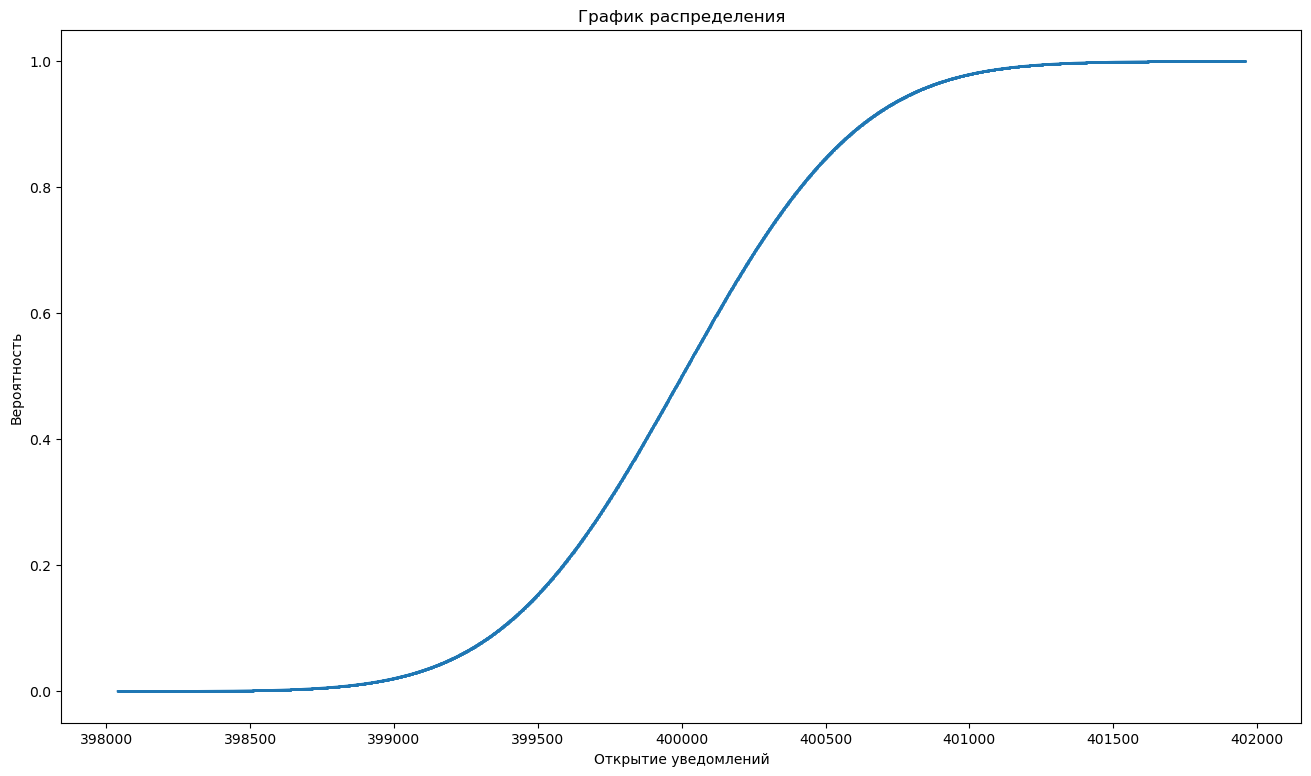

Вероятность открытия 399500 уведомлений: 0.15


In [49]:
n = 1000000  # Отправленные уведомления
p = 0.4      # Вероятность успеха 
k = 399500   # Плановый показатель

mu = n * p
sigma = sqrt(n * p * (1 - p)) 

# Границы промежутка
left = int(n * p - 4 * sigma)
right = int(n * p + 4 * sigma)

# Набор значений биномиальной величины
x = list(range(max(0, left), right))

plt.figure(figsize=(16, 9))
ax = plt.subplot()
ax.plot(x, binom.cdf(x, n, p), 'o-', ms=1)

plt.xlabel('Открытие уведомлений')
plt.ylabel('Вероятность')
plt.title('График распределения')
plt.show()

# Расчёт искомой вероятности
probability = st.binom.cdf(k, n, p)
print('Вероятность открытия', k, 'уведомлений:', round(probability, 2))

**Ответ:**  
Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составляет около 15%

# Выводы

В ходе исследования мы проанализировали данные более, чем 18000 поездок пользователей приложения GoFast и вот, что нам удалось узнать:

 ### География
 * Самым популярными городами по количеству пользователей приложения являются Пятигорск, Екатеринбург и Ростов-на-Дону
 * Меньше всего пользователей приложения в Омске, Тюмени и Москве.

### Использование подписки
* Тех, кто пользуется самокатами без подпиcки на **19%** больше, чем тех, кто оплачивает подписку **ultra**

Это наблюдение поможет точнее прогнозировать общую прибыль сервиса.

### Возраст пользователей
* Чаще всего самокатами пользуются люди в возрасте около 25 лет
* Самым молодым пользователям — 12
* Самым взрослым — 43

Эти наблюдения помогут лучше сегментировать Целевую Аудиторию для настройки таргетированной рекламы.

### Данные о поездках
* Чаще всего пользователи выбирают самокат, чтобы проехать на нём около 3,2 км
* Самые длинные поездки имеют протяжеённость чуть более 7,2 км

* Чаще всего пользователи проводят в поездке около 17 минут
* Самые долгие поездки могут длиться около 40 минут

Эти наблюдения помогут точнее рассчитать ресурс самокатов и частоту сервисного обслуживания.

### Проверка гипотез
#### Гипотеза №1 — Пользователи с подпиской тратят больше времени на поездки
* Не опроверглась

#### Гипотеза №2 — Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров
* Не опроверглась

#### Гипотеза №3 — Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки
* Не опроверглась

#### Гипотеза №4 — Из-за обновления сервера количество обращинй в поддержку снизилось
* Необходима проверка на рельных данных



### Распределения
#### Отправка промокодов
* Необходимо разослать минимум 1172 промокода, чтобы вероятность не выполнить план по продлённым подпискам была примерно 5%.

####  Отправка push-уведомлений
* Вероятность того, что 1 млн отправденных уведомлений, откроют не более 399,5 тыс. пользователей составляет около 15%